# Averaging Hypothesis Imposition

## Intro
* **Date**: 1/13/2021
* **What**: This is a simple MWTA network, but there are actually 2 back-and-forths between the input and the sparse layer before the sparse layer is trained.  The first forward feed is just the input, and then the sparse layer sends back its reconstruction, and then the second forward feed is the average between the input and the reconstruction.  The sparse layer then takes that average as its input, and performs training based on its reconstruction of that input.
* **Why**: Given the huge amount of data the brain has to process, enforcing higher-level hypotheses on lower levels would mean much less processing for the brain.  I'm not entirely sure how to go about this, so I decided to first try the simplest possible method: averaging.
* **Hopes**: Honestly, I mostly just hope everything doesn't blow up. I'm going to train this on some noisy data, and it would be dope to see even better reconstructions than I saw previously.
* **Limitations**: Given the nature of my attempts at new things, it's very possible that everything could blow up.  I suppose we'll see if that happens.

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from numba import njit
from time import time

(train_x, train_y), (test_x, test_y) = mnist.load_data()

m_flat_tr = train_x.reshape(train_x.shape[0], -1) / 255.0
m_flat_te = test_x.reshape(test_x.shape[0], -1) / 255.0 

m_tr_len, m_len = m_flat_tr.shape

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val, vmin=0)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [2]:
gp_tr = cp.asarray(m_flat_tr)

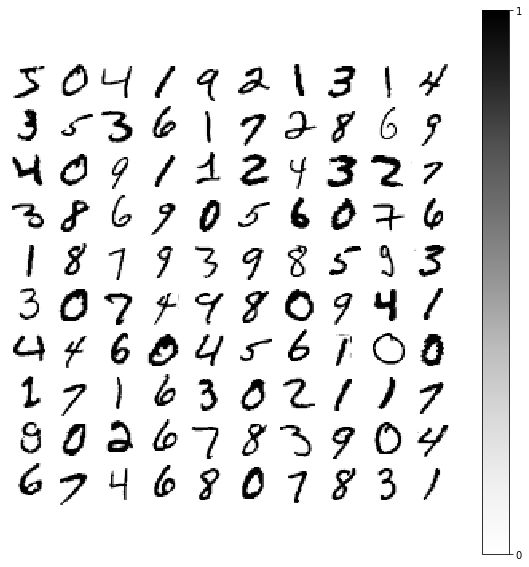

In [3]:
fig = plt.figure(figsize=(10, 10))

draw_weights(gp_tr.get(), 10, 10, 28, fig)

In [38]:
def reconstruct(img_i, w, Kx, Ky, gp, vmax, vmin, n_w):
    s_len = 28

    img = gp[img_i]

    v = img.reshape(-1, 1)
    p = w @ v
    winners = cp.argsort(p, axis=0)[-n_w:]
    mask = cp.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o
    
    o1 = o

    v_new = (v + r) / 2
    p = w @ v_new
    winners = cp.argsort(p, axis=0)[-n_w:]
    mask = cp.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o

    plt.figure(figsize=(8, 2))

    plt.subplot(1, 4, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape(s_len, s_len).get(), cmap="Greys", vmax=vmax, vmin=vmin)
    
    plt.subplot(1, 4, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o1.reshape(Ky, Kx).get(), cmap="Greys")

    plt.subplot(1, 4, 3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o.reshape(Ky, Kx).get(), cmap="Greys")

    plt.subplot(1, 4, 4)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(r.reshape(s_len, s_len).get(), cmap="Greys", vmax=vmax, vmin=vmin)

    plt.show()

Good to see MNIST hasn't changed ;)

## Analysis Dialog

Aight fam.  Let's do this.

<IPython.core.display.Javascript object>


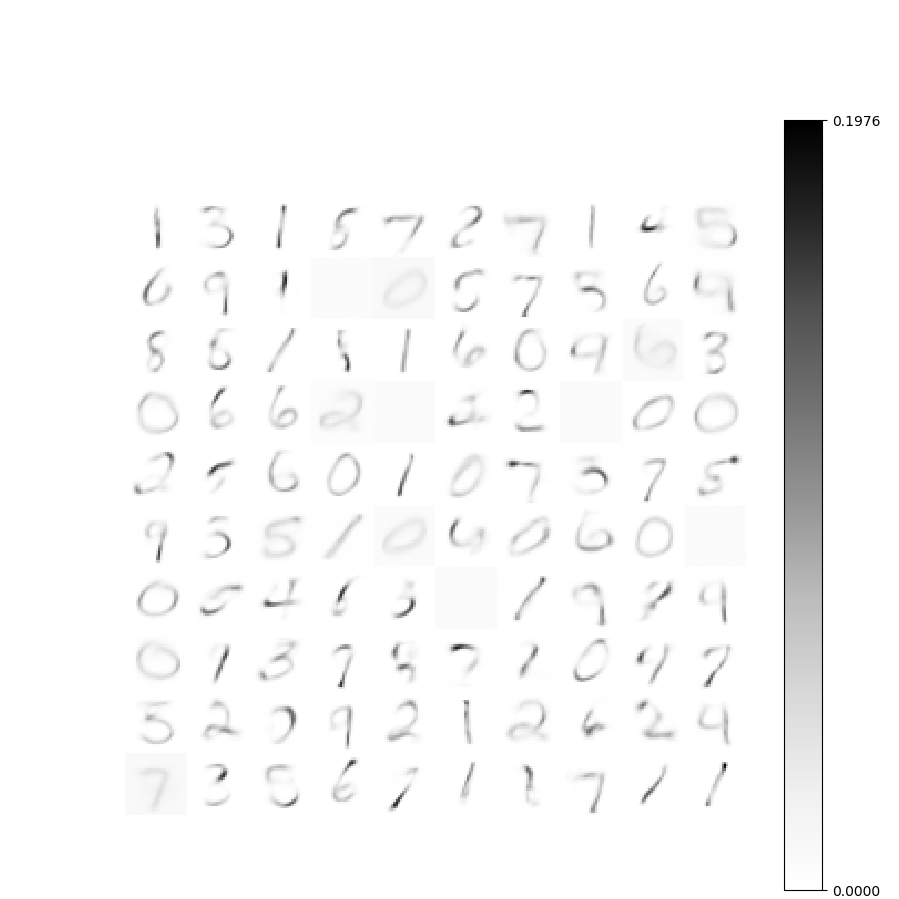

 27%|██▋       | 1628/6000 [00:01<00:04, 1036.01it/s]


KeyboardInterrupt: 

In [6]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 6000

Kx = 10
Ky = 10
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 5 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(.1, .11, (N, m_len))
xi = 0.002

for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        v_new = (v + r) / 2
        p = w @ v_new
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        mod_r = cp.maximum(r, prec)
        e = v_new - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


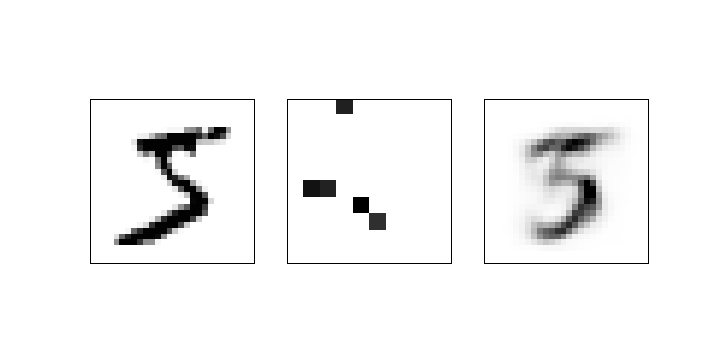

<IPython.core.display.Javascript object>


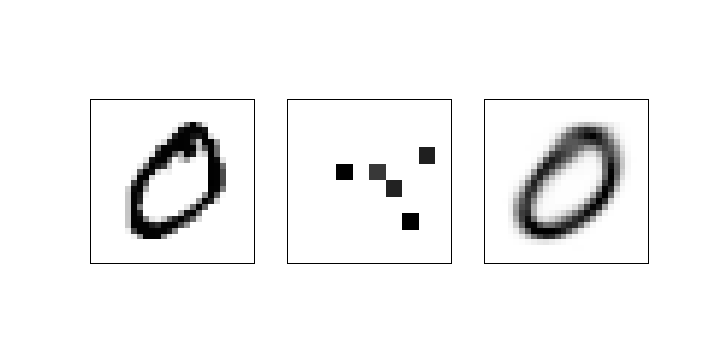

<IPython.core.display.Javascript object>


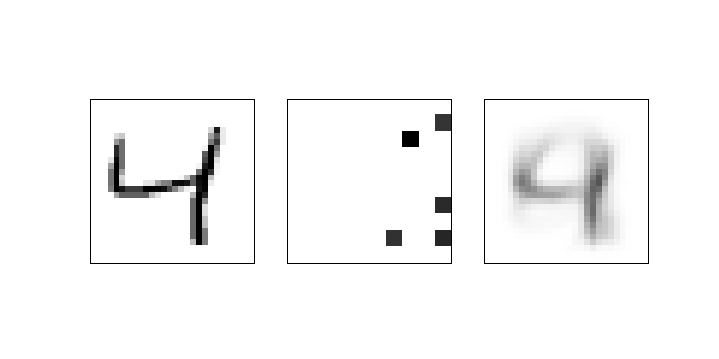

<IPython.core.display.Javascript object>


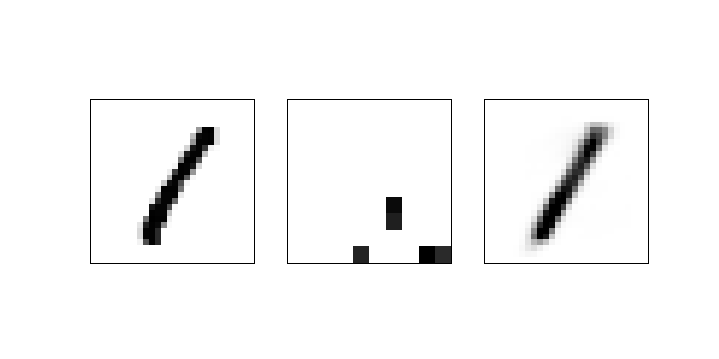

<IPython.core.display.Javascript object>


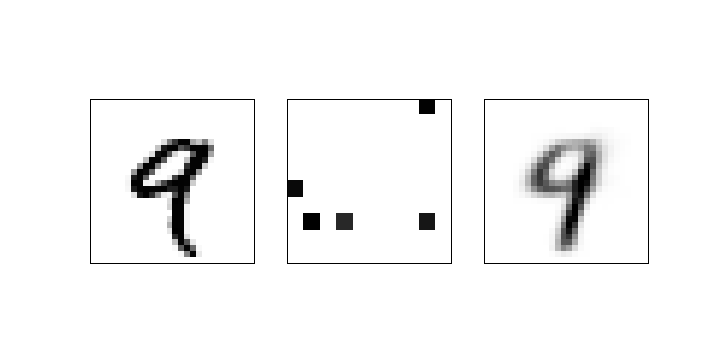

<IPython.core.display.Javascript object>


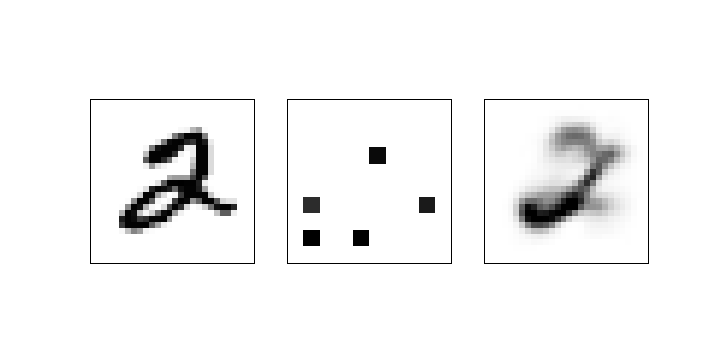

<IPython.core.display.Javascript object>


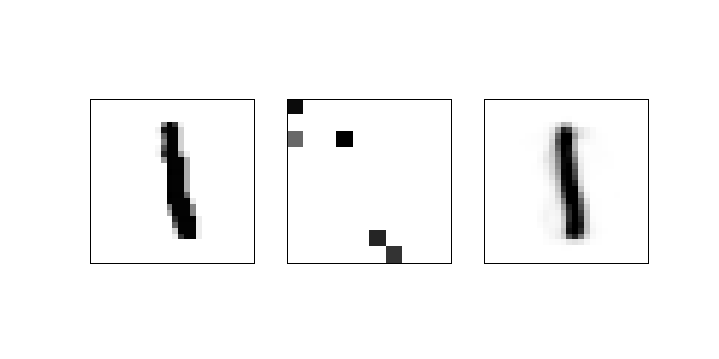

<IPython.core.display.Javascript object>


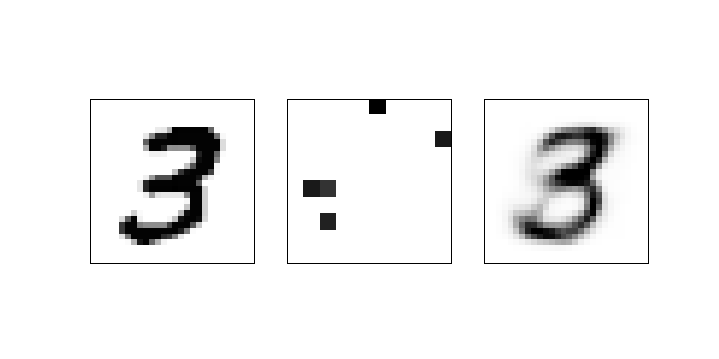

<IPython.core.display.Javascript object>


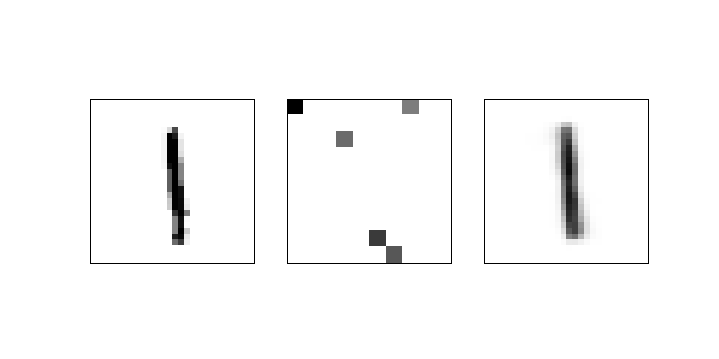

<IPython.core.display.Javascript object>


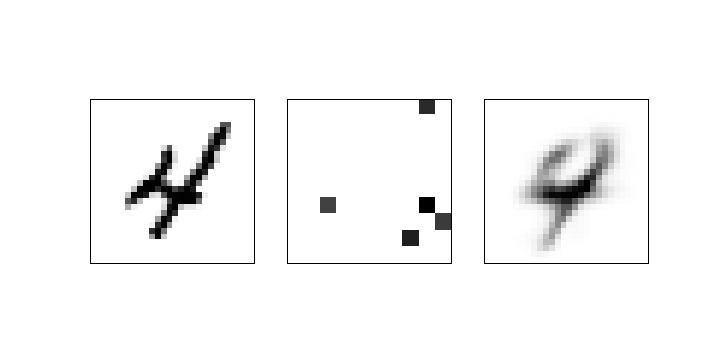

In [8]:
offset = 0

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_tr, 1, 0, n_w)

Alright, alright.  Not too bad.  Time to up the neuron count a bit.

<IPython.core.display.Javascript object>


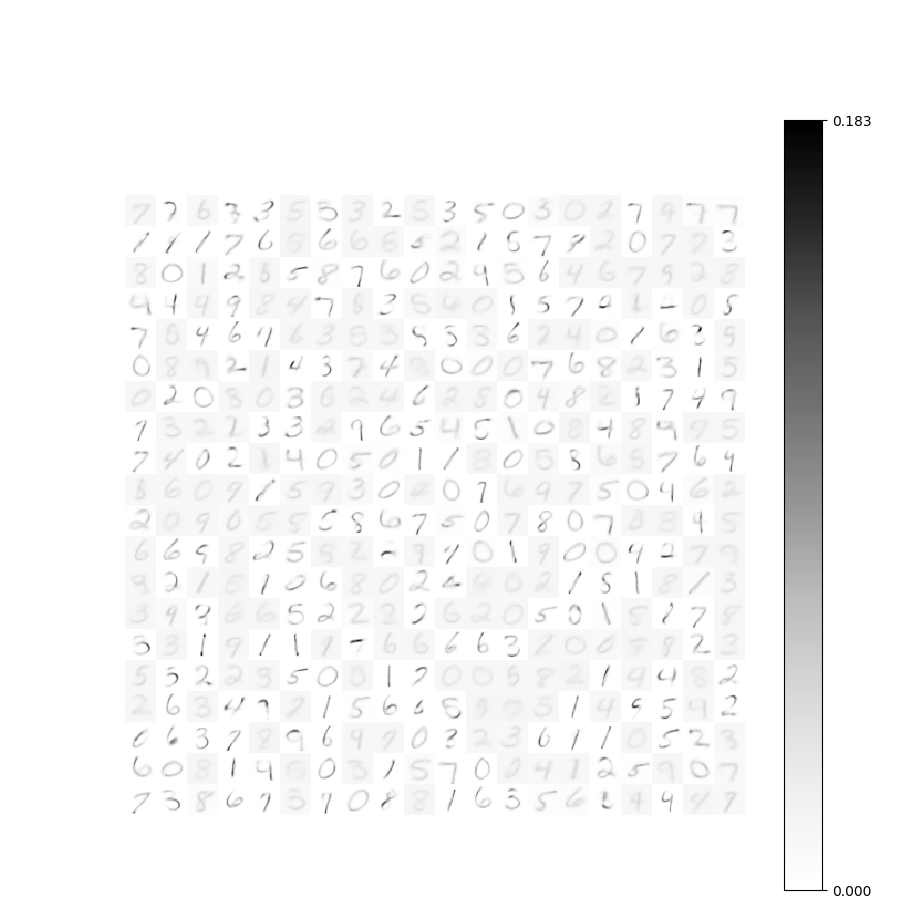

 62%|██████▏   | 3716/6000 [00:03<00:02, 1058.27it/s]


KeyboardInterrupt: 

In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 6000

Kx = 20
Ky = 20
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 5 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(.1, .11, (N, m_len))
w = w / np.linalg.norm(w, axis=1).reshape(-1, 1)
xi = 0.005

for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        v_new = (v + r) / 2
        p = w @ v_new
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        mod_r = cp.maximum(r, prec)
        e = v_new - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


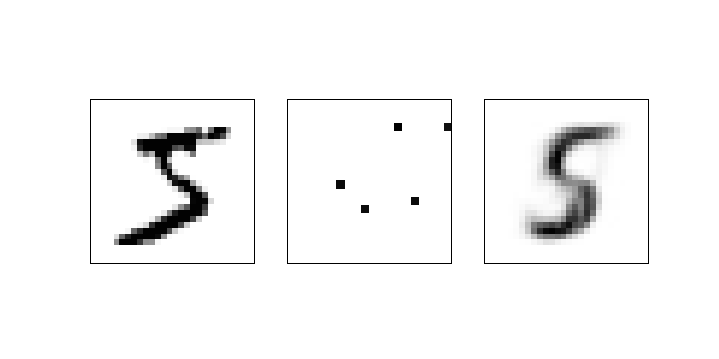

<IPython.core.display.Javascript object>


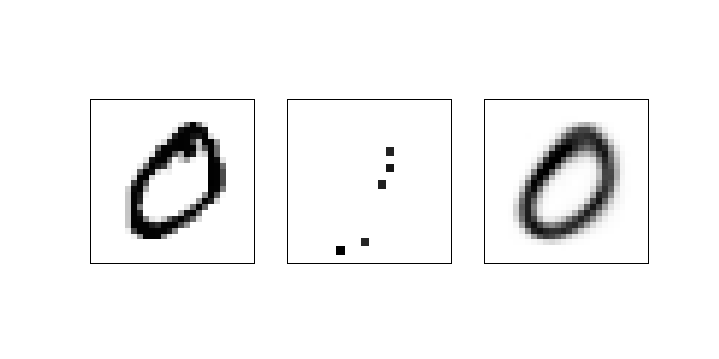

<IPython.core.display.Javascript object>


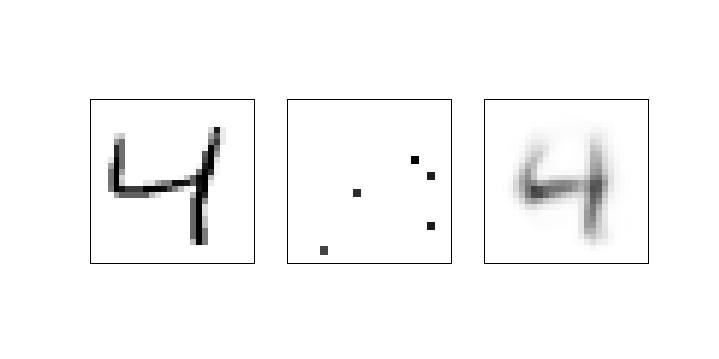

<IPython.core.display.Javascript object>


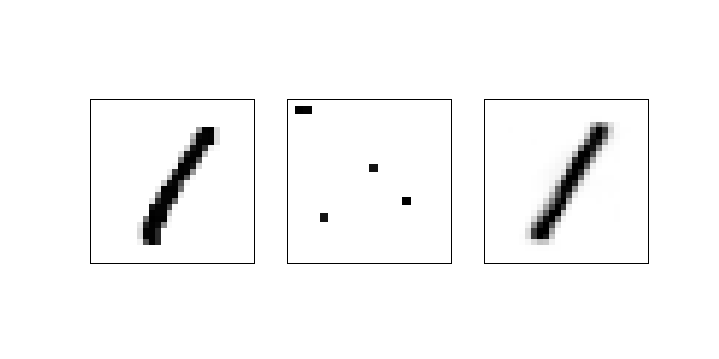

<IPython.core.display.Javascript object>


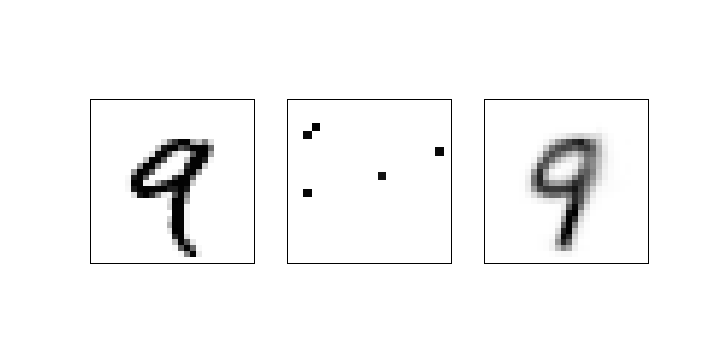

<IPython.core.display.Javascript object>


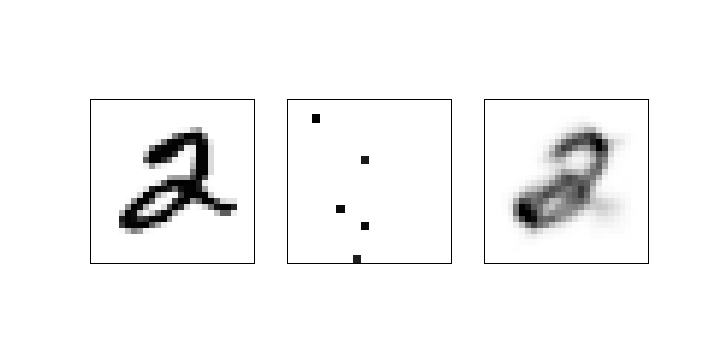

<IPython.core.display.Javascript object>


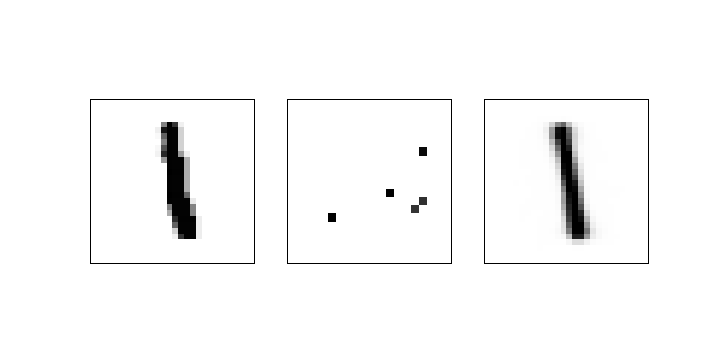

<IPython.core.display.Javascript object>


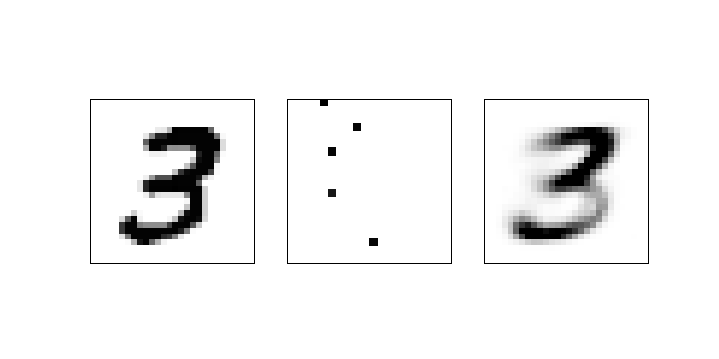

<IPython.core.display.Javascript object>


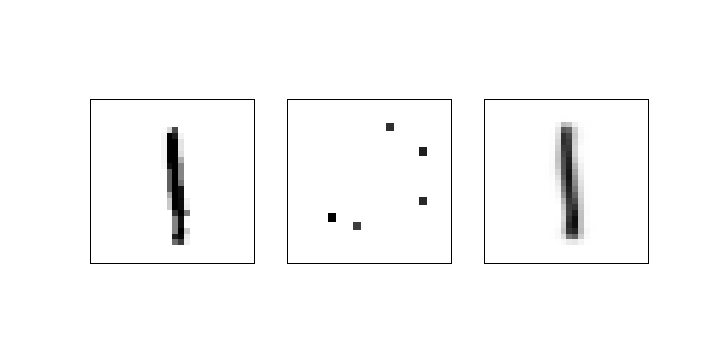

<IPython.core.display.Javascript object>


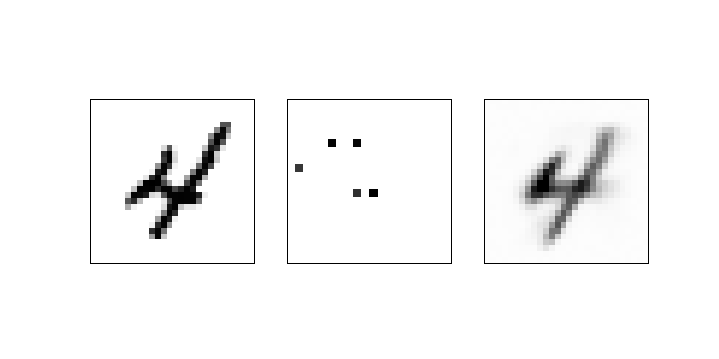

In [12]:
offset = 0

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_tr, 1, 0, n_w)

It doesn't seem to be utilizing all of the neurons very well.  Hmm.  That's a problem.  I'm going to try a much larger network and then move onto noisy data.

<IPython.core.display.Javascript object>


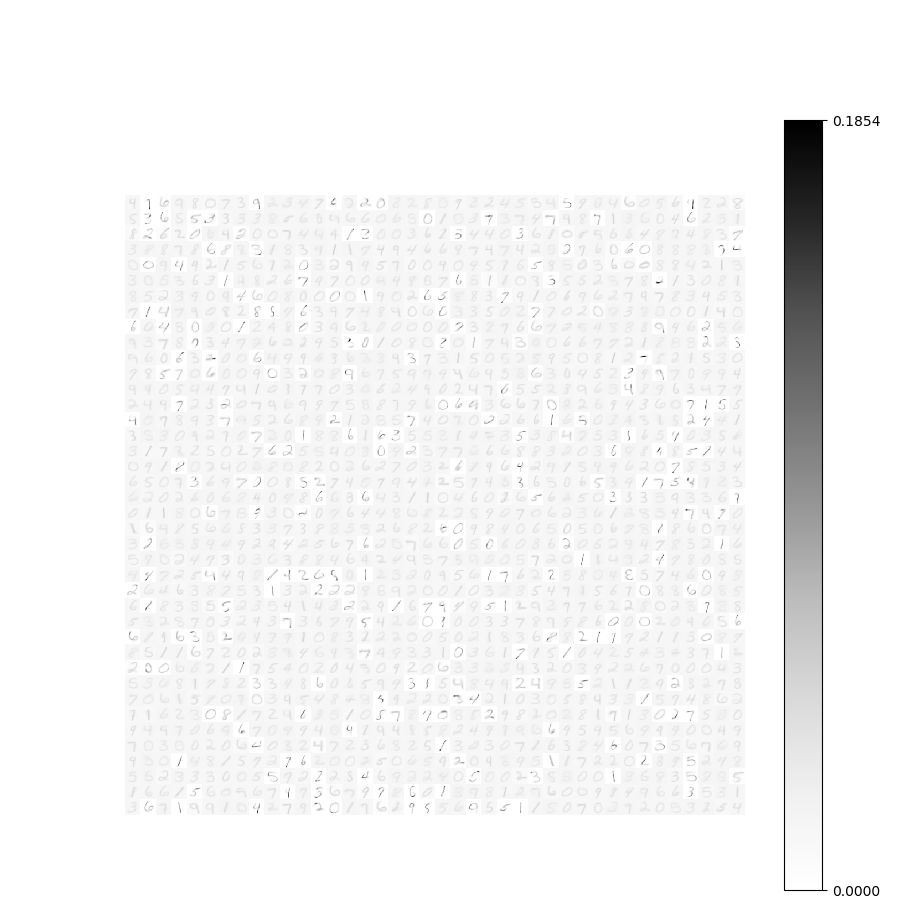

 25%|██▌       | 1518/6000 [00:01<00:04, 974.39it/s] 


KeyboardInterrupt: 

In [13]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 6000

Kx = 40
Ky = 40
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 5 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(.1, .11, (N, m_len))
w = w / np.linalg.norm(w, axis=1).reshape(-1, 1)
xi = 0.005

for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        v_new = (v + r) / 2
        p = w @ v_new
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        mod_r = cp.maximum(r, prec)
        e = v_new - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


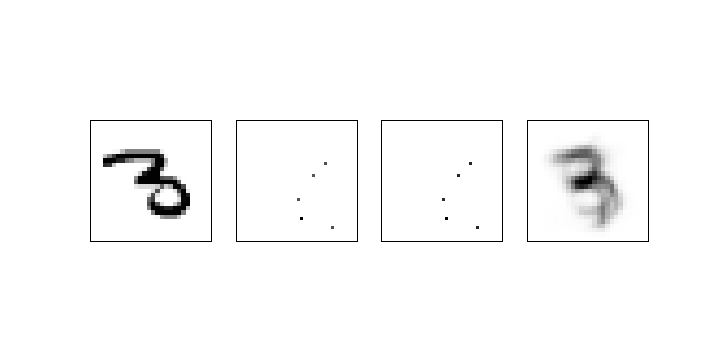

<IPython.core.display.Javascript object>


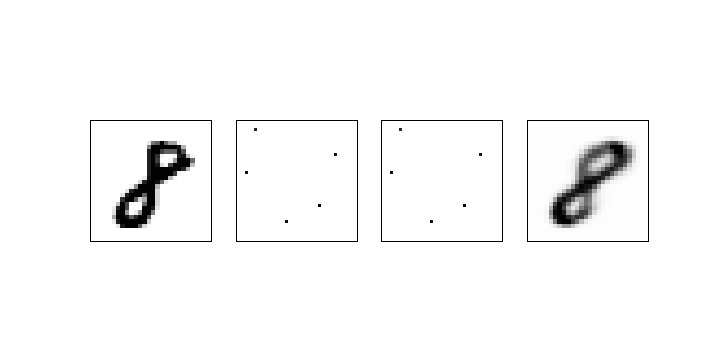

<IPython.core.display.Javascript object>


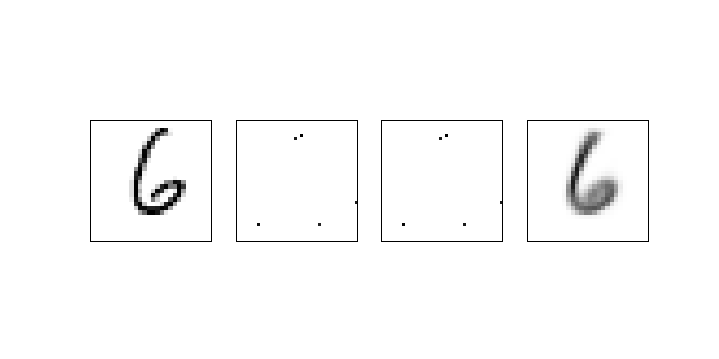

<IPython.core.display.Javascript object>


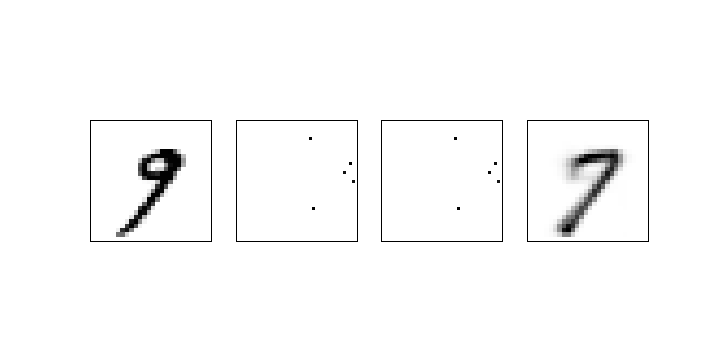

<IPython.core.display.Javascript object>


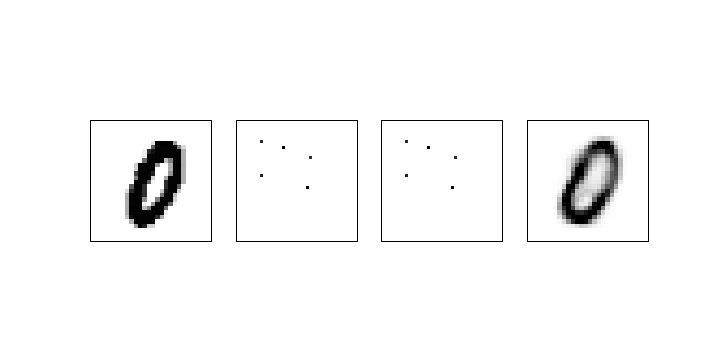

<IPython.core.display.Javascript object>


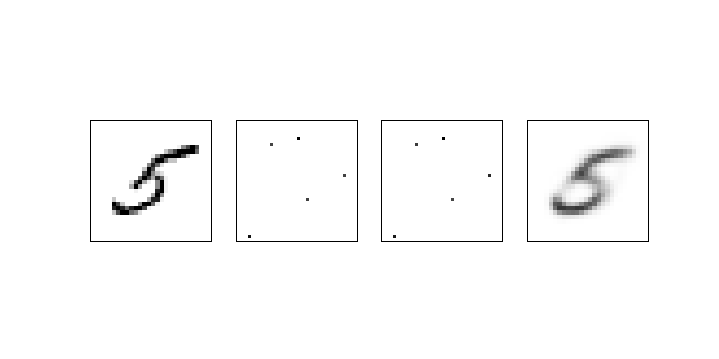

<IPython.core.display.Javascript object>


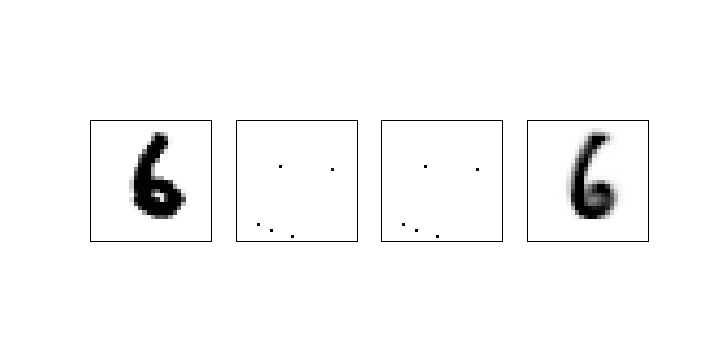

<IPython.core.display.Javascript object>


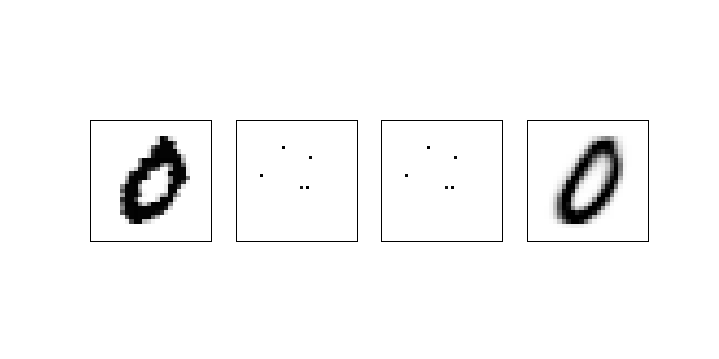

<IPython.core.display.Javascript object>


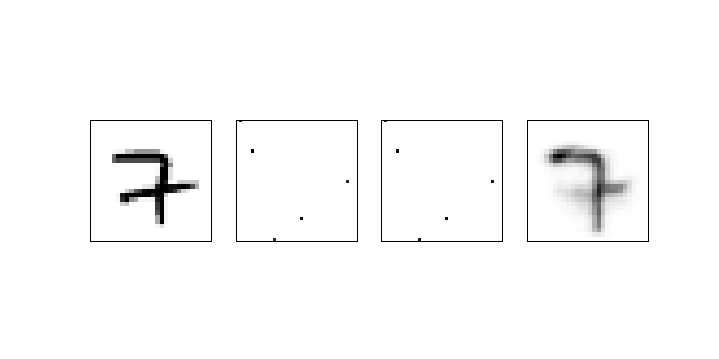

<IPython.core.display.Javascript object>


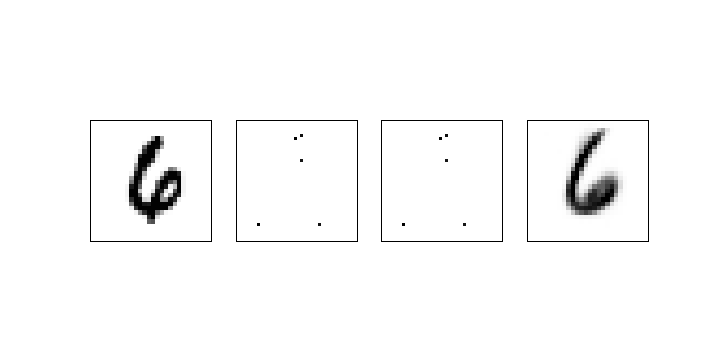

In [20]:
offset = 30

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_tr, 1, 0, n_w)

This is interesting.  It appears as though the network moves the input closer to the canonical version of the digit, and then trains on that.  

Here's something else.  The reason why I think many of the neurons aren't improving over time it because they act like "filters."  What I mean is that on the off-chance that they are activated, they move the input closer to something that would tend to activate the strongest neurons, meaning they themselves would never train.  Interesting.  

Ok, I think I have a solution to this.  I think I'm going to train the neurons slightly during the first pass and reconstruction, but do a more major learning step after the hypothesis has been enforced.  That way the neurons will still be learning and hopefully moving toward more useful prototypes.

<IPython.core.display.Javascript object>


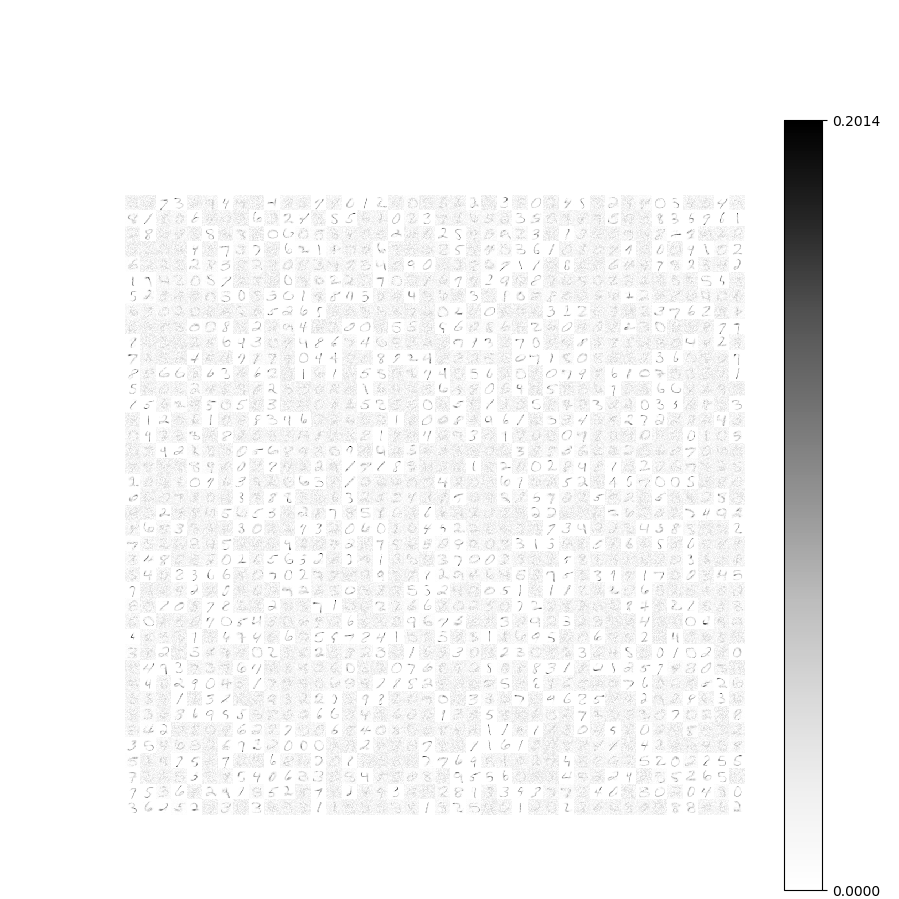

 22%|██▏       | 1333/6000 [00:01<00:05, 832.71it/s]


KeyboardInterrupt: 

In [27]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 6000

Kx = 40
Ky = 40
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 5 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, .1, (N, m_len))

xi = 0.01

xi_alpha = 0.0
xi_beta = 0.002

for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi
        
        v_new = (v + r) / 2
        p = w @ v_new
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        mod_r = cp.maximum(r, prec)
        e = v_new - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


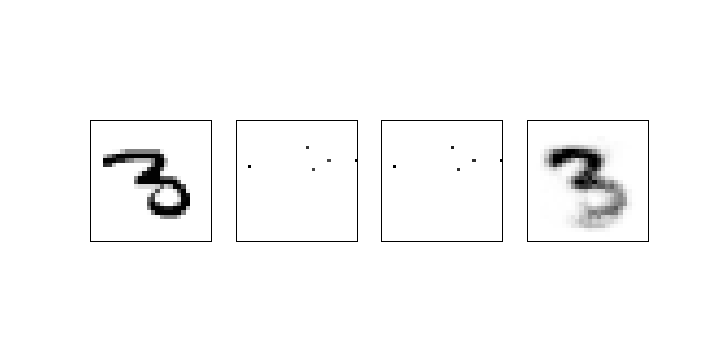

<IPython.core.display.Javascript object>


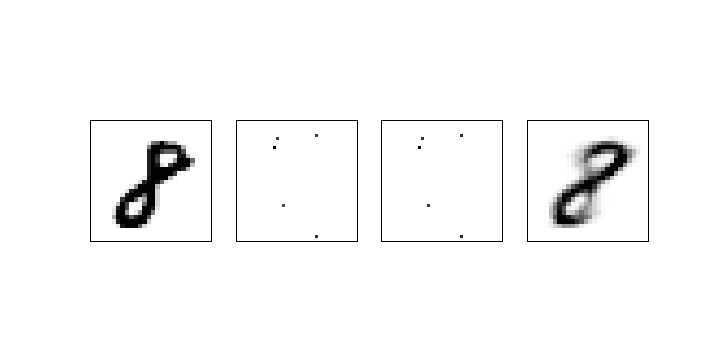

<IPython.core.display.Javascript object>


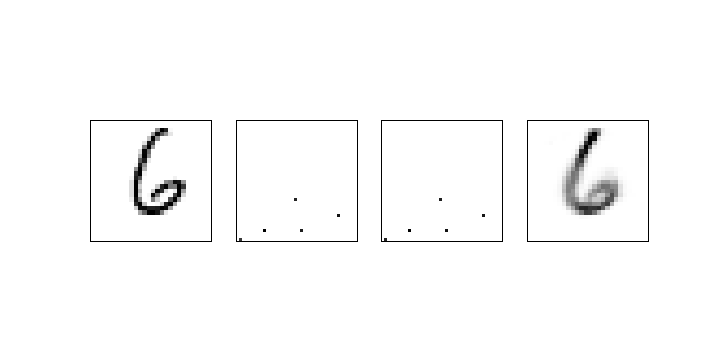

<IPython.core.display.Javascript object>


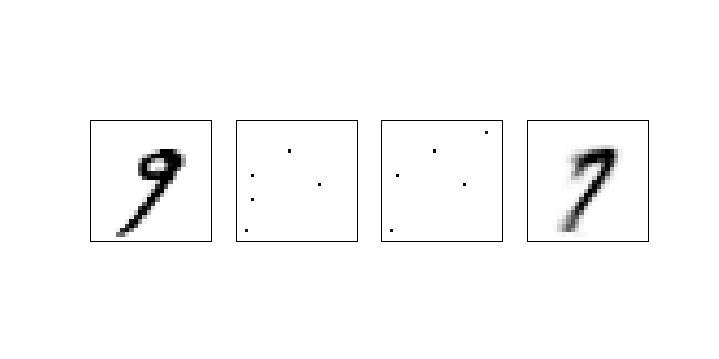

<IPython.core.display.Javascript object>


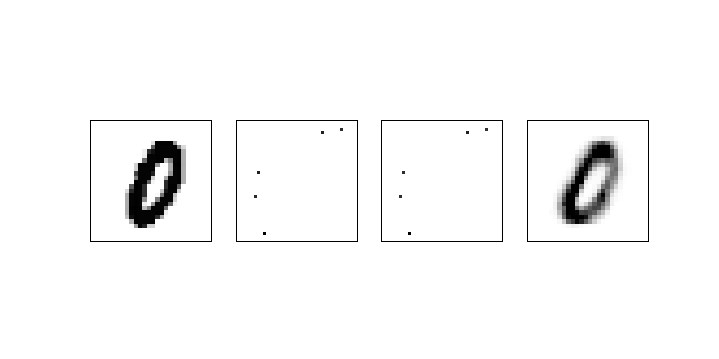

<IPython.core.display.Javascript object>


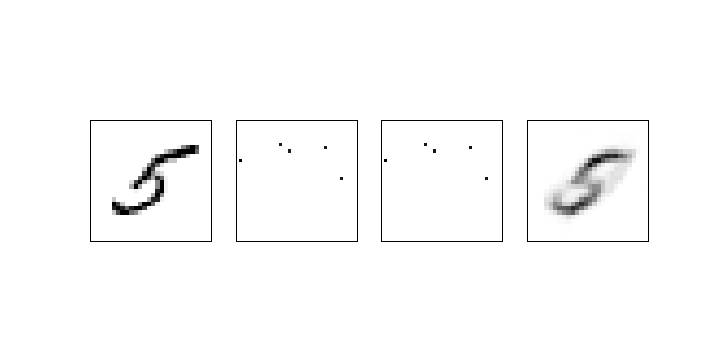

<IPython.core.display.Javascript object>


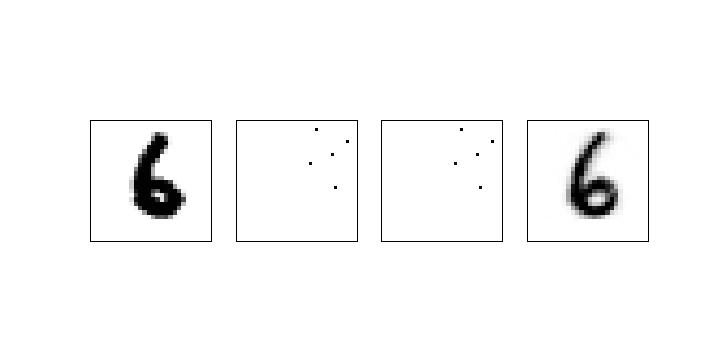

<IPython.core.display.Javascript object>


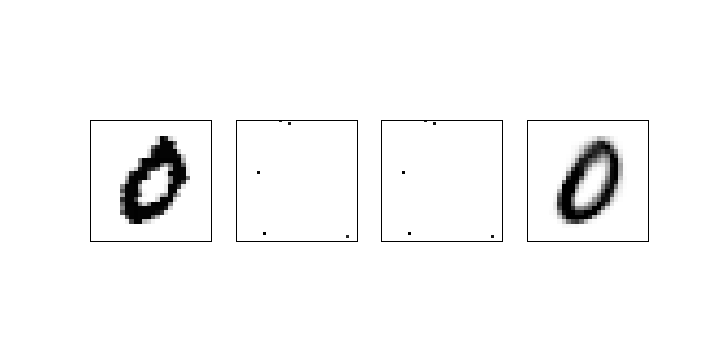

<IPython.core.display.Javascript object>


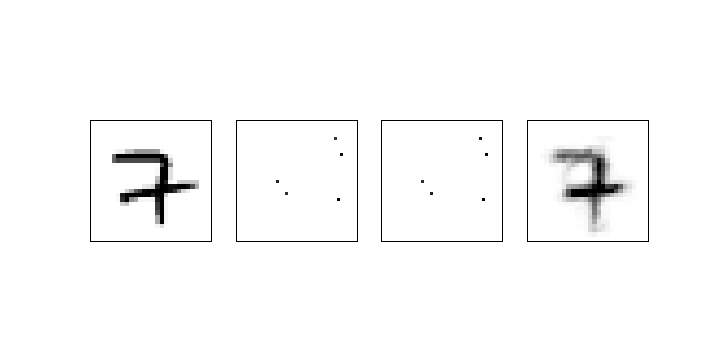

<IPython.core.display.Javascript object>


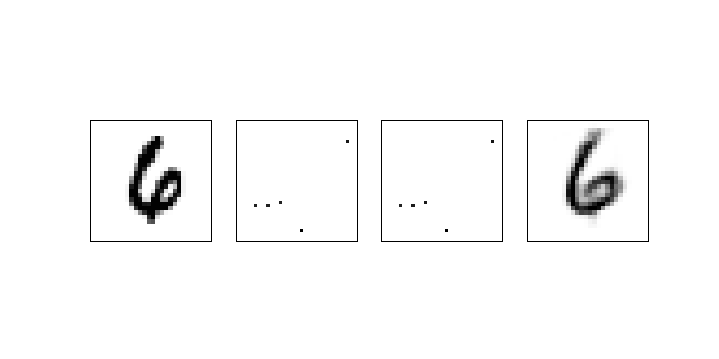

In [28]:
offset = 30

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_tr, 1, 0, n_w)

Eh. Gross.  Alright I'm going to train the original on noisy data, see how that goes.

In [29]:
m_noise = np.clip(m_flat_tr + np.random.normal(0, 0.2, m_flat_tr.shape), 0, 1)
gp_noise = cp.asarray(m_noise)

<IPython.core.display.Javascript object>


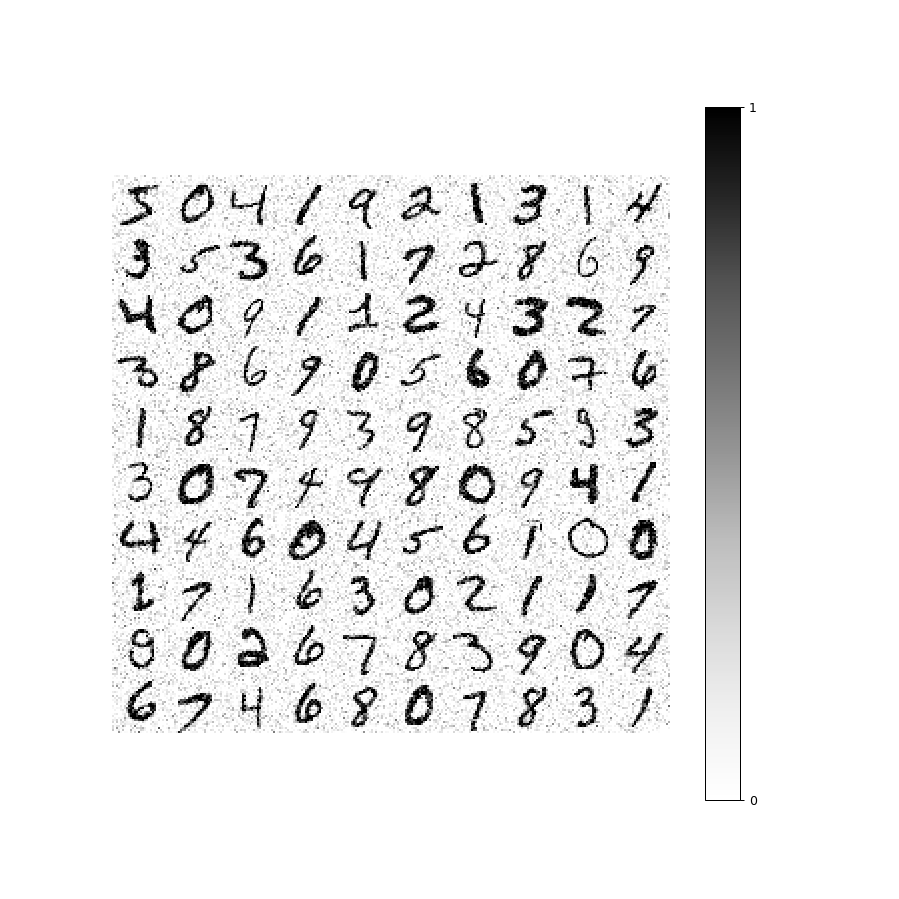

In [30]:
fig = plt.figure(figsize=(10, 10))

draw_weights(m_noise, 10, 10, 28, fig)

<IPython.core.display.Javascript object>


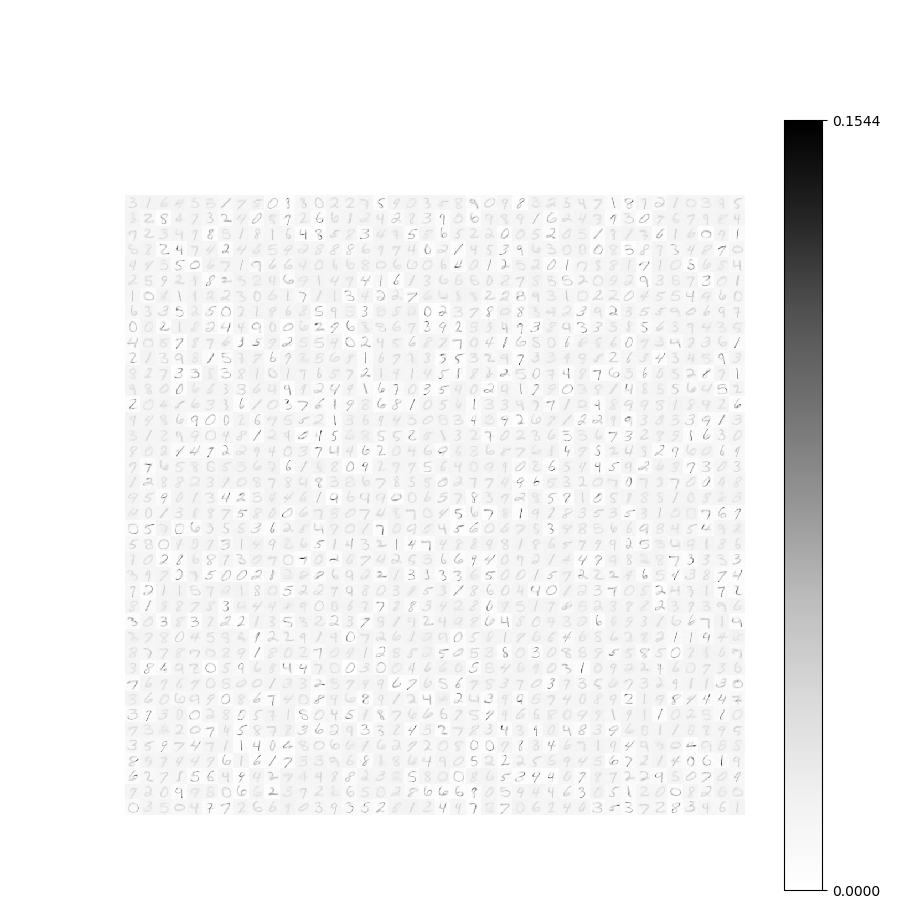

 54%|█████▍    | 3245/6000 [00:03<00:02, 953.31it/s]


KeyboardInterrupt: 

In [33]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 6000

Kx = 40
Ky = 40
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 5 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(.1, .11, (N, m_len))
w = w / np.linalg.norm(w, axis=1).reshape(-1, 1)
xi = 0.01

for ep in range(Nep):
    inputs = gp_noise[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        v_new = cp.clip((v + r) / 2, 0, 1)
        p = w @ v_new
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        mod_r = cp.maximum(r, prec)
        e = v_new - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


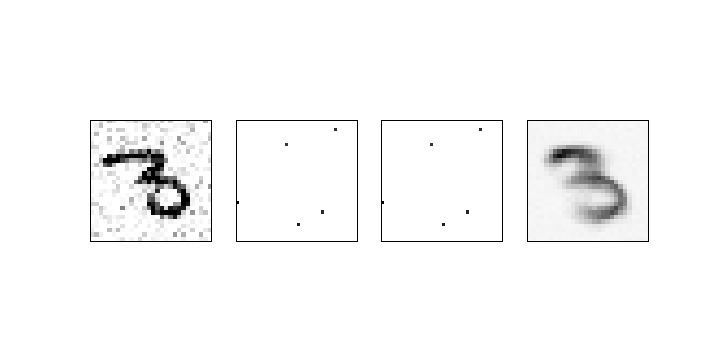

<IPython.core.display.Javascript object>


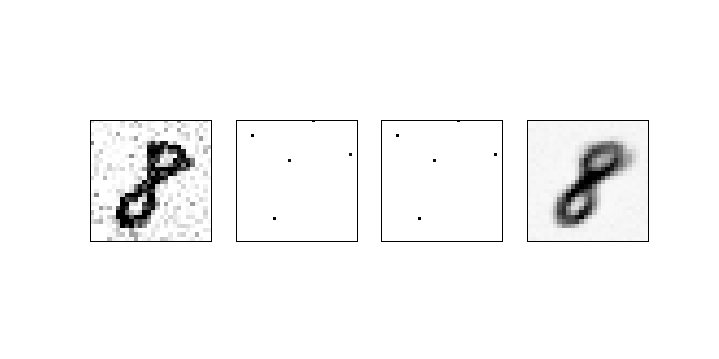

<IPython.core.display.Javascript object>


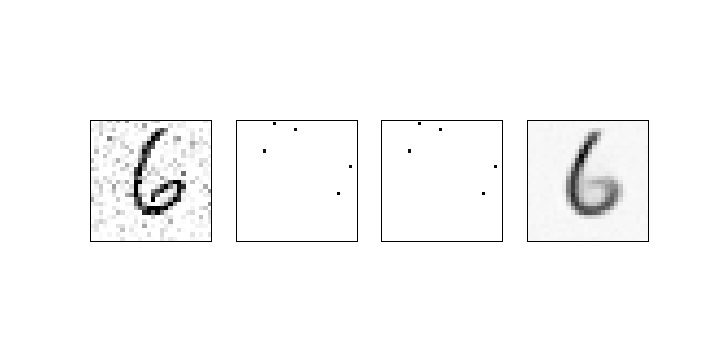

<IPython.core.display.Javascript object>


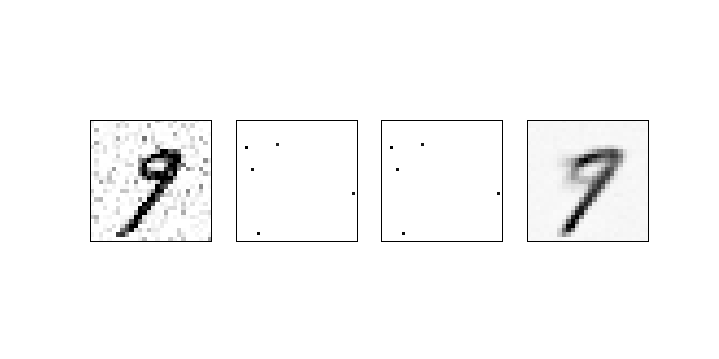

<IPython.core.display.Javascript object>


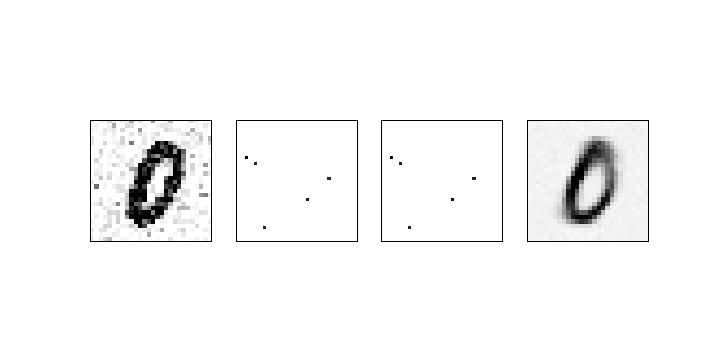

<IPython.core.display.Javascript object>


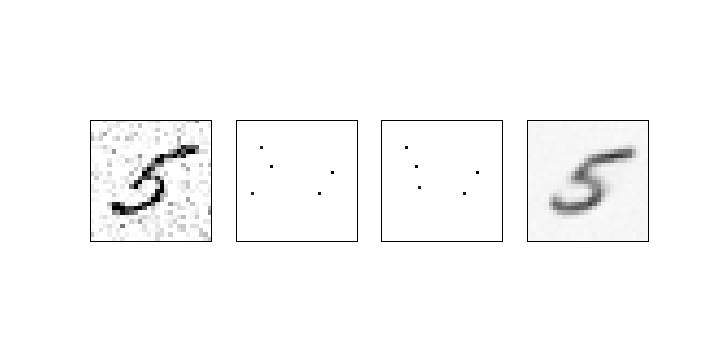

<IPython.core.display.Javascript object>


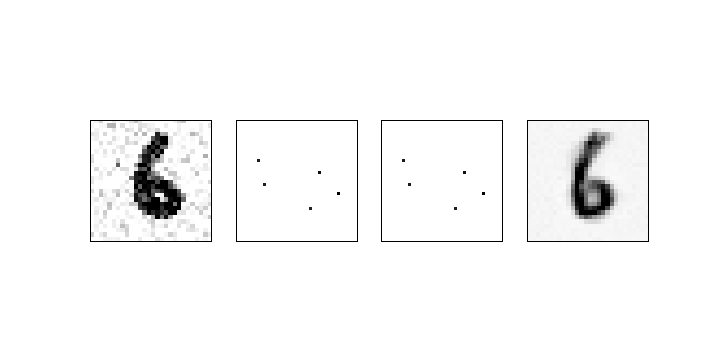

<IPython.core.display.Javascript object>


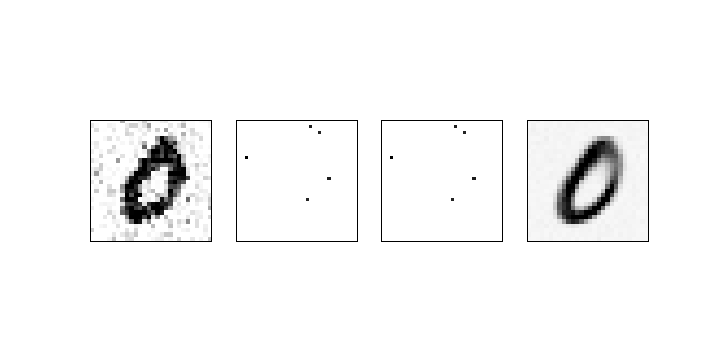

<IPython.core.display.Javascript object>


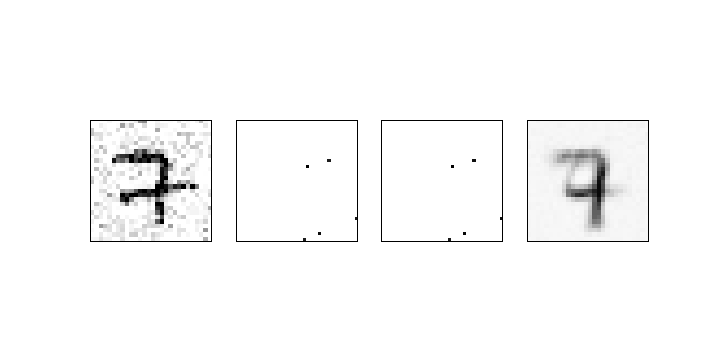

<IPython.core.display.Javascript object>


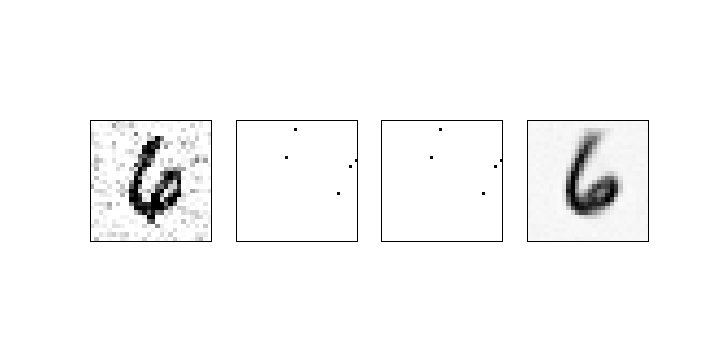

In [34]:
offset = 30

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_noise, 1, 0, n_w)

Hmm.  Ok, those reconstructions aren't bad... let's see how it does with other noise profiles.

In [35]:
m_noise5 = np.clip(m_flat_tr + np.random.normal(0, 0.5, m_flat_tr.shape), 0, 1)
gp_noise5 = cp.asarray(m_noise5)

<IPython.core.display.Javascript object>


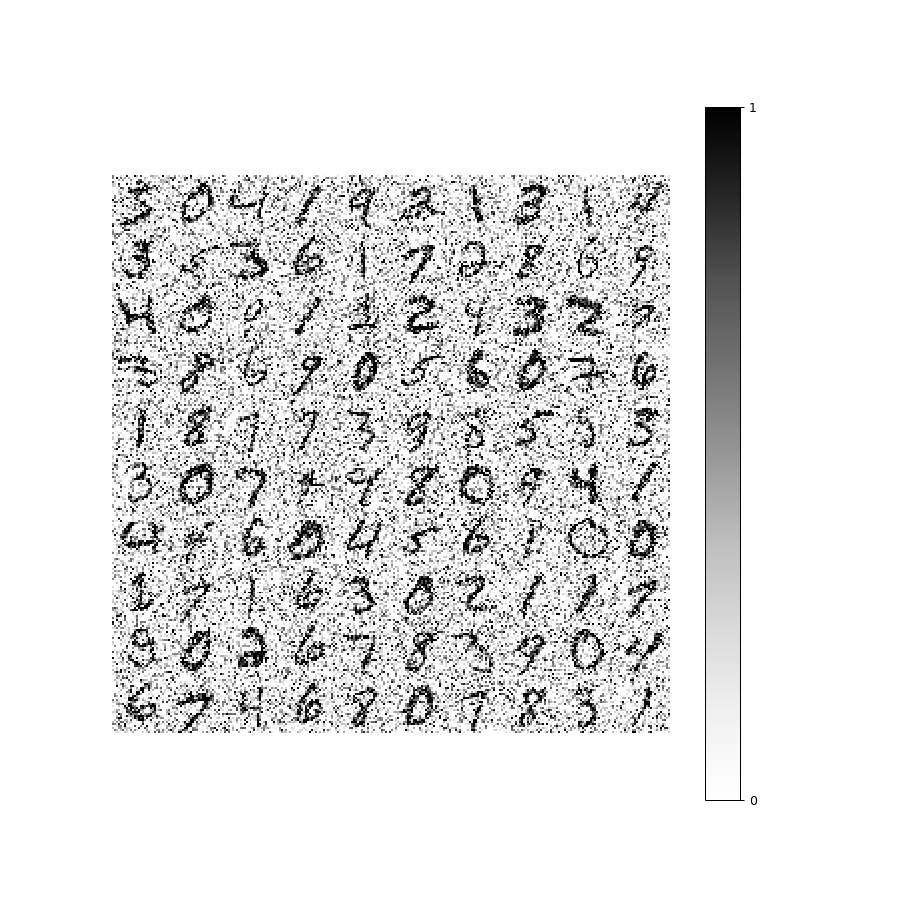

In [36]:
fig = plt.figure(figsize=(10, 10))

draw_weights(m_noise5, 10, 10, 28, fig)

<IPython.core.display.Javascript object>


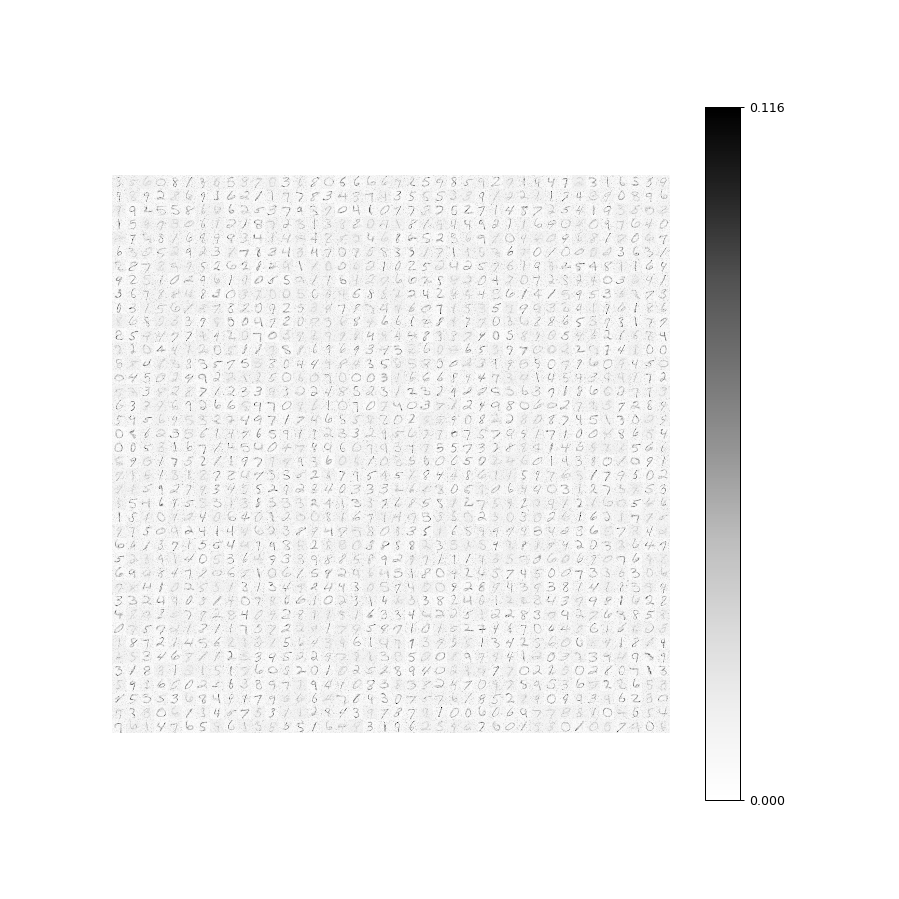

100%|██████████| 6000/6000 [00:06<00:00, 981.29it/s]


In [37]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 6000

Kx = 40
Ky = 40
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 5 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(.1, .11, (N, m_len))
w = w / np.linalg.norm(w, axis=1).reshape(-1, 1)
xi = 0.01

for ep in range(Nep):
    inputs = gp_noise5[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        v_new = cp.clip((v + r) / 2, 0, 1)
        p = w @ v_new
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        mod_r = cp.maximum(r, prec)
        e = v_new - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


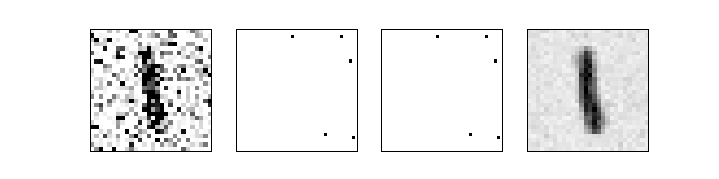

<IPython.core.display.Javascript object>


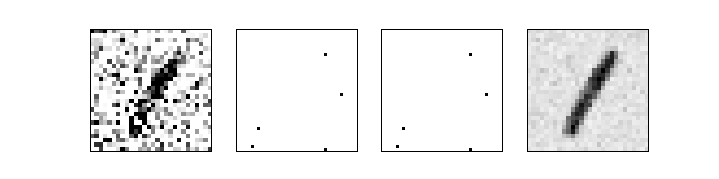

<IPython.core.display.Javascript object>


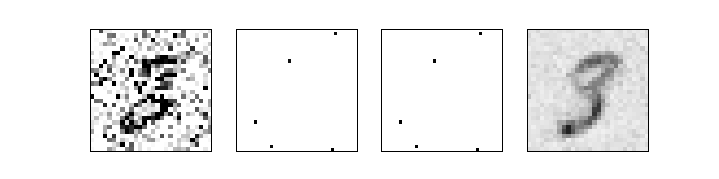

<IPython.core.display.Javascript object>


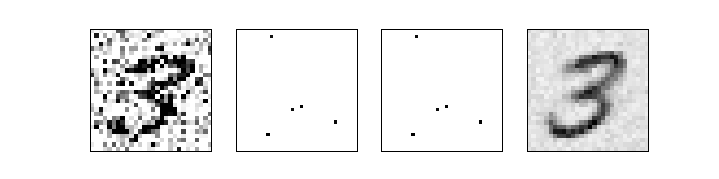

<IPython.core.display.Javascript object>


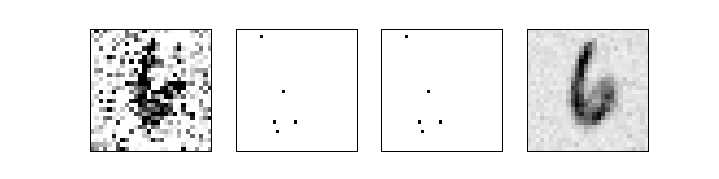

<IPython.core.display.Javascript object>


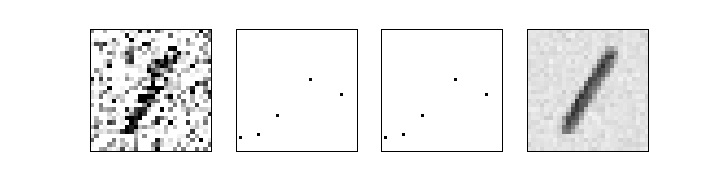

<IPython.core.display.Javascript object>


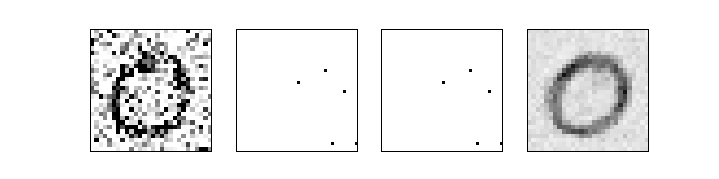

<IPython.core.display.Javascript object>


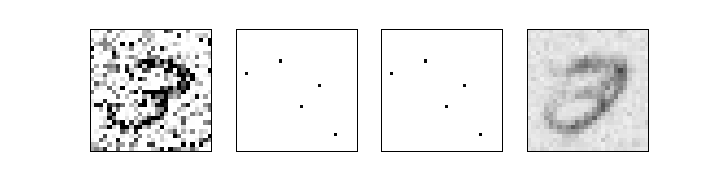

<IPython.core.display.Javascript object>


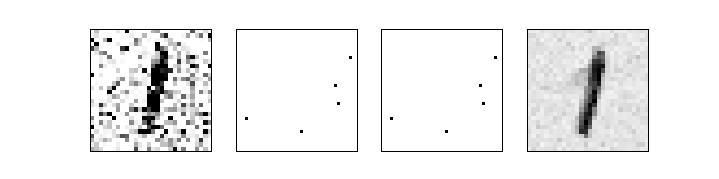

<IPython.core.display.Javascript object>


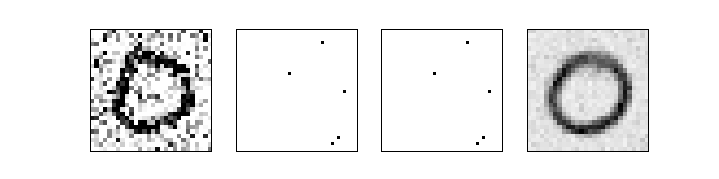

In [42]:
offset = 200

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_noise5, 1, 0, n_w)

I mean, it's still doing a reasonable job, I suppose.  Still I'm not a huge fan of how few neurons are being utilized. 

Let's try this on the brutal noise profile and see what happens.

In [43]:
m_noise0 = np.clip(m_flat_tr + np.random.normal(-1, 0.5, m_flat_tr.shape), 0, 1)
gp_noise0 = cp.asarray(m_noise0)

<IPython.core.display.Javascript object>


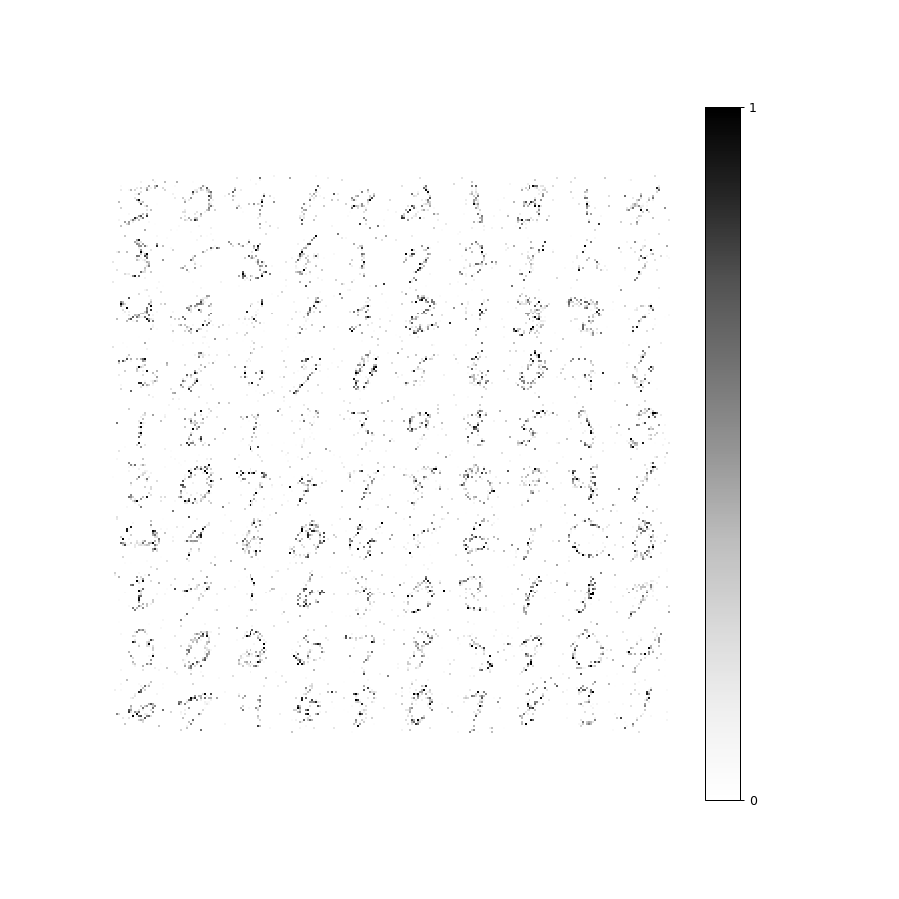

In [44]:
fig = plt.figure(figsize=(10, 10))

draw_weights(gp_noise0.get(), 10, 10, 28, fig)

<IPython.core.display.Javascript object>


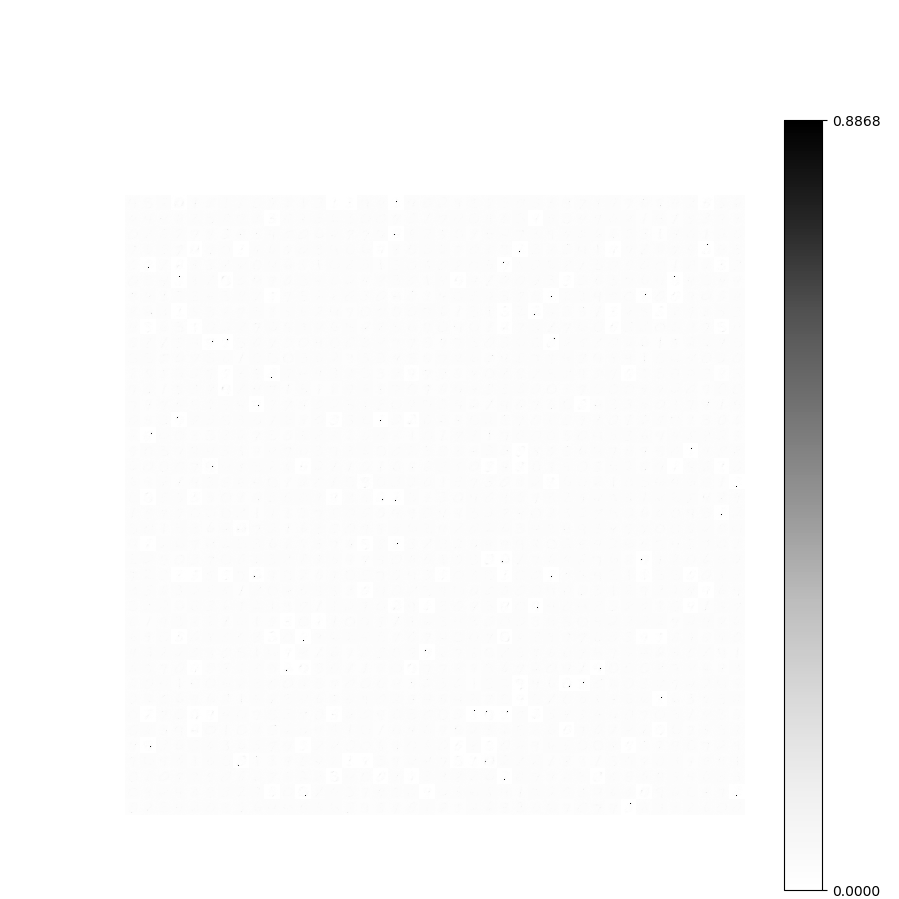

 41%|████      | 2449/6000 [00:02<00:03, 949.39it/s]


KeyboardInterrupt: 

In [45]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 6000

Kx = 40
Ky = 40
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 5 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(.1, .11, (N, m_len))
w = w / np.linalg.norm(w, axis=1).reshape(-1, 1)
xi = 0.01

for ep in range(Nep):
    inputs = gp_noise0[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        v_new = cp.clip((v + r) / 2, 0, 1)
        p = w @ v_new
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        
        mod_r = cp.maximum(r, prec)
        e = v_new - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


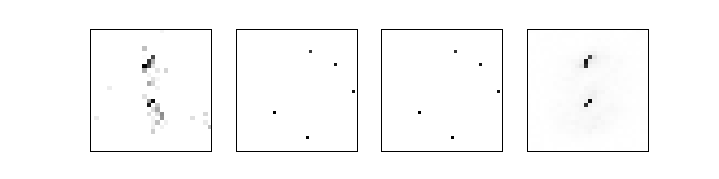

<IPython.core.display.Javascript object>


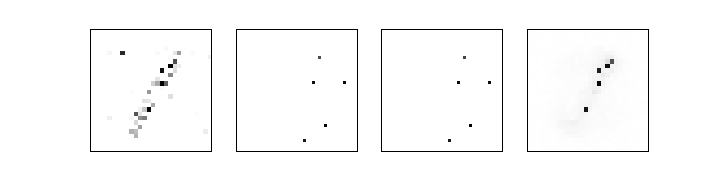

<IPython.core.display.Javascript object>


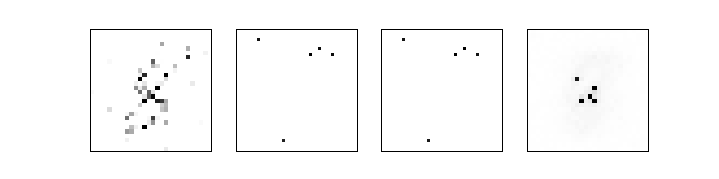

<IPython.core.display.Javascript object>


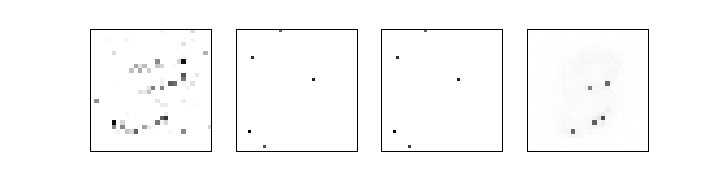

<IPython.core.display.Javascript object>


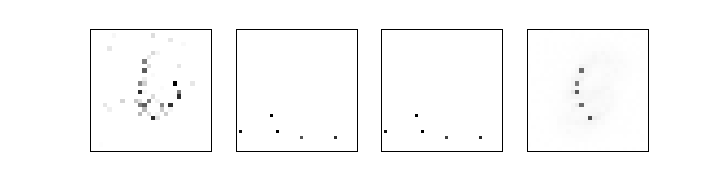

<IPython.core.display.Javascript object>


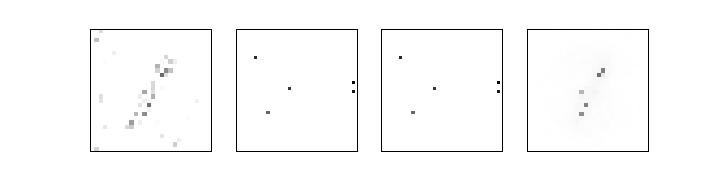

<IPython.core.display.Javascript object>


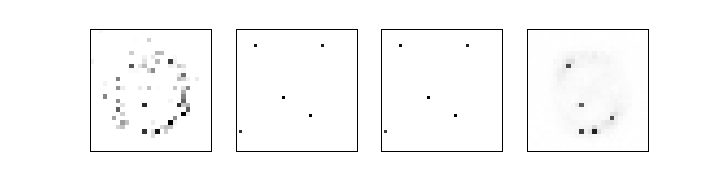

<IPython.core.display.Javascript object>


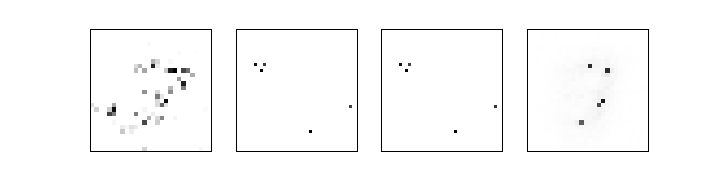

<IPython.core.display.Javascript object>


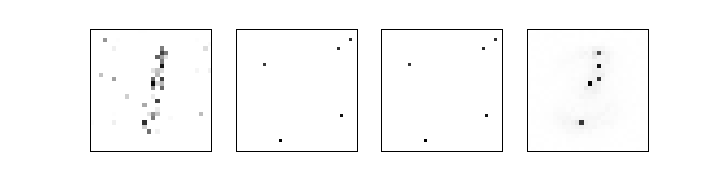

<IPython.core.display.Javascript object>


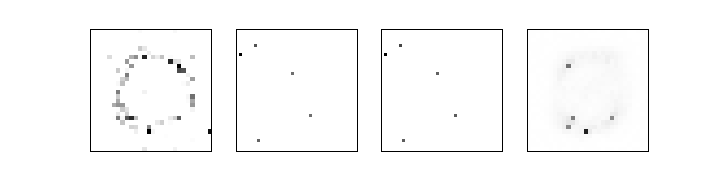

In [46]:
offset = 200

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_noise0, 1, 0, n_w)

Ugh.  Yeah, I mean it's not great.  And by that, I of course mean that it's quite awful.  Yikes.  I think I'm going to take a walk to think about all this.  First I'm going to shut down the p-instance, of course.

## Conclusions

This form of hypothesis imposition is simply not great.  It basically is only performing worse than MWTA.  Fantastic. 

One interesting and highly non-trivial thing that we're seeing is that not all of the neurons train the same amount using this form of hypothesis imposition.  I think it's because if the do initially "win" an input, they just alter the input to be more like something that would be "won" by one of the dominant neurons.  That's one explanation for why that's happening.  Man it'll be great to have intelligent hardware to tell me better explanations for what's happening in the network.  

## Next steps

I've been using EMAs to form afinity groups based on time-based locality for the invariant layer, but I think maybe it would be a good idea to use EMAs even with the sparse layer.  The whole point of noise is that it lasts for very short periods of time.  So if the sparse layer was "on" for a longer duration than the average duration of the noise, it would form a more correct representation of the actual persistent structure underlying all the noise.  

But that's just how I think I'd deal with the problems I'm seeing with the brutal noise profile.

That doesn't say anything about hypothesis imposition.  Averaging almost always has bit me in the butt, so I'm thinking maybe doing something more along the lines of addition and subtraction...but I don't even know how that would work.  

Maybe the reason our eyes focus on one thing at a time is that it gives our brain a chance to form the hierarchy of hypotheses necessary to understand the thing on which our eyes are focusing.  That's interesting.  So maybe it's only when there's a major change to the input that the heirarchy is disrupted...hmm I'll have to think on that. 